In [ ]:
!pip install simplejson

     |████████████████████████████████| 129 kB 4.0 MB/s 


In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
from google.colab import drive
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
import json
from os import listdir, mkdir
from os.path import isdir
import os
from math import ceil, isnan
from tqdm import tqdm
import simplejson 

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
BASE_DIR = "/content/drive/Shareddrives/soone/summary_data"

In [ ]:
def get_all_user_id():
    return [f[:-4] for f in listdir("/content/drive/Shareddrives/soone/user_data")]


In [ ]:
def get_toilet_data(id):
    df = pd.read_csv(f"/content/drive/Shareddrives/soone/user_data/{id}.csv", encoding="cp949")
    df = df.dropna(subset=["Act"])
    toilet_list = [[] for _ in range(31)]
    for idx, row in df.iterrows():
        t = datetime.strptime(row["Time"][1:], "%Y-%m-%d %H:%M:%S")
        if  ( "용변" in row["Act"]): # 복약 판단
            toilet_list[t.day-1].append(t.hour + t.minute/60)

    toilet_count = np.array([len(p) for p in toilet_list])
    toilet_count_mean = toilet_count.mean()
    toilet_count_std = toilet_count.std()
    max_toilet_count = max(toilet_count)
    perfect_toilet_count = max_toilet_count * 31
    score = toilet_count.sum() / perfect_toilet_count * 100
    outliers = []
    for i, p in enumerate(toilet_count):
        if abs(p-toilet_count_mean) > toilet_count_std:
            outliers.append(i+1)

    score = (31-toilet_list.count([])) / 31 * 100
    return toilet_list, score, outliers

In [ ]:
def generate_daily_record():
    user_list = get_all_user_id()
    for u in tqdm(user_list):
        toilet_record, score, outliers = get_toilet_data(u)
        # make dir for user data
        if not isdir(os.path.join(BASE_DIR,u)):
            mkdir(os.path.join(BASE_DIR,u))
        # make dir for user sleep data
        if not isdir(os.path.join(BASE_DIR,u, "toilet")):
            mkdir(os.path.join(BASE_DIR,u, "toilet"))
        toilet_dir = os.path.join(BASE_DIR,u, "toilet")
        daily_json_list = [[] for _ in range(ceil(31/7))]
        
        for i, d in enumerate(toilet_record):
            daily_json_list[i//7].append(d)
           
        
        f = open(os.path.join(toilet_dir, "daily.json"), "w")
       
        simplejson.dump(daily_json_list, fp=f, indent=4*" ", ignore_nan=True)
        f.close()
        
        f = open(os.path.join(toilet_dir, "outlier.json"), "w")
        simplejson.dump(outliers, fp=f, indent=" "*4)
        f.close()


In [ ]:
generate_daily_record()

100%|██████████| 170/170 [00:11<00:00, 14.76it/s]


In [ ]:
a = np.array([1,5,3,2,5,7])
np.argpartition(a, -3)[-4:]

array([2, 4, 1, 5])

In [ ]:
def generate_monthly_record():
    user_list = get_all_user_id()
    for u in tqdm(user_list):
        toilet_record, score, _ = get_toilet_data(u)

        time_count = [0 for _ in range(24)]
        for day in toilet_record:
            for h in day:
                time_count[int(h)] += 1
        time_count = np.array(time_count)

        top5 = np.argsort(time_count)[-5:].tolist()
        toilet_count = np.array([len(p) for p in toilet_record])
        toilet_count_mean = toilet_count.mean()

        monthly_record = {"avg_count": toilet_count_mean, "top_5": top5, "score": score}

        toilet_dir = os.path.join(BASE_DIR,u, "toilet")

        f = open(os.path.join(toilet_dir,"monthly.json"), "w")
        simplejson.dump(monthly_record, fp=f, indent=4*" ", ignore_nan=True)
        f.close()



        


       



In [ ]:
generate_monthly_record()

100%|██████████| 170/170 [00:10<00:00, 16.06it/s]


In [ ]:
df.iloc[1].isna()

brkfst    False
lnch      False
dnr        True
count     False
Name: 1, dtype: bool

In [ ]:
def check_score_hist():
    user_list = get_all_user_id()
    score_list = [ get_meal_data(u)[1] for u in get_all_user_id()]
    plt.hist(score_list)
    print(f"min : {min(score_list)}, max : {max(score_list)}")
    plt.show()

min : 3.349644656479509, max : 88.41554662334516


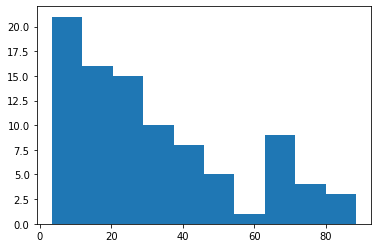

In [ ]:
check_score_hist()

In [ ]:
def generate_all_user_data():
    user_list = get_all_user_id()

    score_list = []
    time_count = [0 for _ in range(24)]
    avg_count_list = []

    # make dir for user data
    if not isdir(os.path.join(BASE_DIR,"all_user")):
        mkdir(os.path.join(BASE_DIR,"all_user"))
    # make dir for user sleep data
    if not isdir(os.path.join(BASE_DIR,"all_user", "toilet")):
        mkdir(os.path.join(BASE_DIR,"all_user", "toilet"))

    for u in tqdm(user_list):
        toilet_record, score, _ = get_toilet_data(u)

        score_list.append(score)
        time_count = [0 for _ in range(24)]
        for day in toilet_record:
            for h in day:
                time_count[int(h)] += 1
        time_count = np.array(time_count)

        toilet_count = np.array([len(p) for p in toilet_record])
        toilet_count_mean = toilet_count.mean()
        
        avg_count_list.append(toilet_count_mean)
        

    mean_score = np.array(score_list).mean()
    top5 = np.argsort(time_count)[-5:].tolist()
    avg_count = np.array(avg_count_list).mean()

    all_user_data = {"avg_count": avg_count, "top_5": top5, "score": mean_score}

    toilet_dir = os.path.join(BASE_DIR,"all_user", "toilet")

    f = open(os.path.join(toilet_dir,"all_user.json"), "w")
    simplejson.dump(all_user_data, fp=f, indent=4*" ", ignore_nan=True)
    f.close()




In [ ]:
generate_all_user_data()

100%|██████████| 170/170 [00:09<00:00, 17.78it/s]


In [ ]:
def generate_outlier():
    user_list = get_all_user_id()
    for u in user_list:
        